# Load packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

from liver_microsome_prediction.utils import *

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import AdamW
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, StandardScaler

os.environ['DGLBACKEND'] = 'pytorch'

# Load dataset

In [3]:
train_data, test_data = pd.read_csv(PATH.train), pd.read_csv(PATH.test)
targets = ['MLM', 'HLM']
test_data[targets] = 0
full_data = pd.concat([train_data, test_data])

In [4]:
train_data.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          483 non-null    object 
 1   SMILES                      483 non-null    object 
 2   AlogP                       482 non-null    float64
 3   Molecular_Weight            483 non-null    float64
 4   Num_H_Acceptors             483 non-null    int64  
 5   Num_H_Donors                483 non-null    int64  
 6   Num_RotatableBonds          483 non-null    int64  
 7   LogD                        483 non-null    float64
 8   Molecular_PolarSurfaceArea  483 non-null    float64
 9   MLM                         483 non-null    int64  
 10  HLM                         483 non-null    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 41.6+ KB


In [7]:
def plot_features(df):
    num_cols = train_data.select_dtypes('number').columns
    fig, axes = plt.subplots(1, len(num_cols), figsize=(30, 2))
    for ax, col in zip(axes.flat, num_cols):
        df[[col]].plot.hist(bins=200, ax=ax)

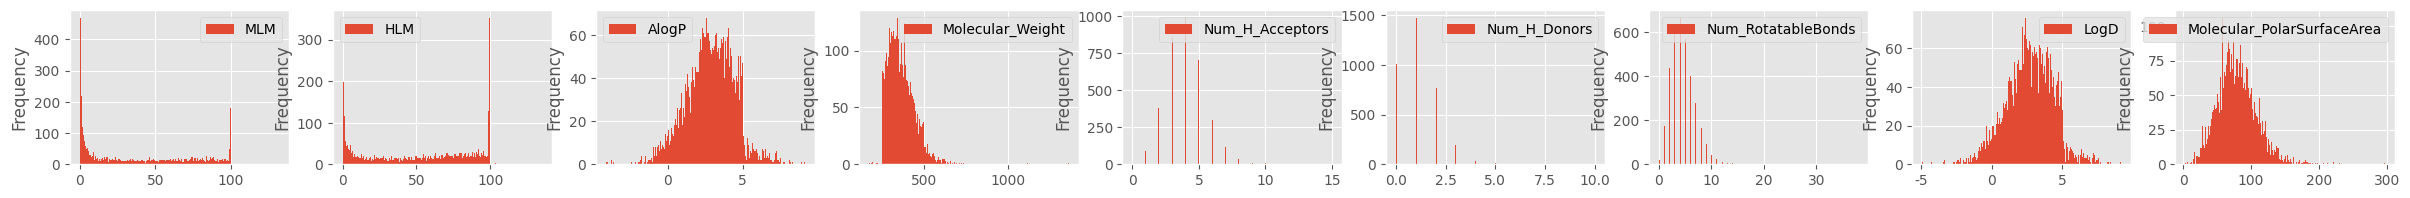

In [8]:
plot_features(train_data)

# Split dataset

In [9]:
n_bins = 5
train_data[f'equal_freq_bin_MLM'] = pd.qcut(train_data.MLM, q=n_bins, duplicates='drop')
train_data[f'equal_freq_bin_HLM'] = pd.qcut(train_data.HLM, q=n_bins, duplicates='drop')

In [10]:
train_data['equal_freq_bin_MLM'].value_counts().sort_index()

equal_freq_bin_MLM
(-0.001, 1.364]     700
(1.364, 11.728]     699
(11.728, 45.363]    700
(45.363, 77.866]    699
(77.866, 131.72]    700
Name: count, dtype: int64

In [11]:
train_data['equal_freq_bin_HLM'].value_counts().sort_index()

equal_freq_bin_HLM
(-0.001, 8.799]      700
(8.799, 42.098]      699
(42.098, 71.062]     700
(71.062, 92.316]     699
(92.316, 135.336]    700
Name: count, dtype: int64

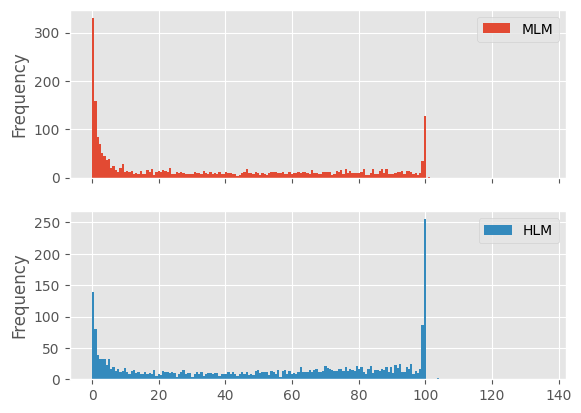

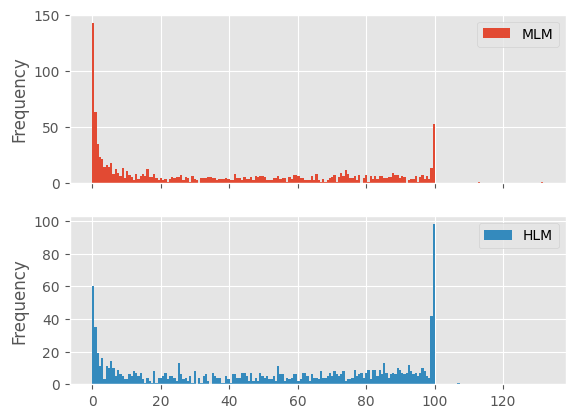

In [12]:
from sklearn.model_selection import train_test_split

def plot_targets(df):
    df[targets].plot.hist(subplots=True, bins=200)
    
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=SEED, stratify=train_data[['equal_freq_bin_MLM', 'equal_freq_bin_HLM']])

plot_targets(train_data)
plot_targets(val_data)

## Imputing

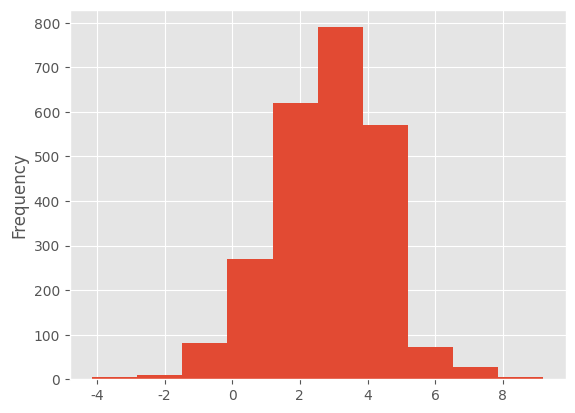

In [13]:
train_data['AlogP'].plot.hist();

In [14]:
AlogP_mean = train_data.AlogP.mean()  # mean is E[AlogP] as normal-like distribution
train_data.loc[train_data.AlogP.isna(), 'AlogP'] = AlogP_mean
val_data.loc[val_data.AlogP.isna(), 'AlogP']     = AlogP_mean
test_data.loc[test_data.AlogP.isna(), 'AlogP']   = AlogP_mean

assert (not train_data.isna().any(axis=None)) and (not test_data.isna().any(axis=None))

## Scaling X

In [15]:
num_features = train_data.select_dtypes('number').drop(columns=targets).columns

X_scaler = StandardScaler()
train_data[num_features] = X_scaler.fit_transform(train_data[num_features])
val_data[num_features]   = X_scaler.transform(val_data[num_features])
test_data[num_features]  = X_scaler.transform(test_data[num_features])

## Scaling y

In [16]:
y_scalers = {target: PowerTransformer(method='box-cox') for target in targets}

transformed = []
for target in targets:
    # all values must be positive
    train_data.loc[train_data[target] == 0, target] = 1e-6
    val_data.loc[val_data[target] == 0, target]     = 1e-6
    train_data[target] = y_scalers[target].fit_transform(train_data[[target]].values)
    val_data[target]   = y_scalers[target].transform(val_data[[target]].values)

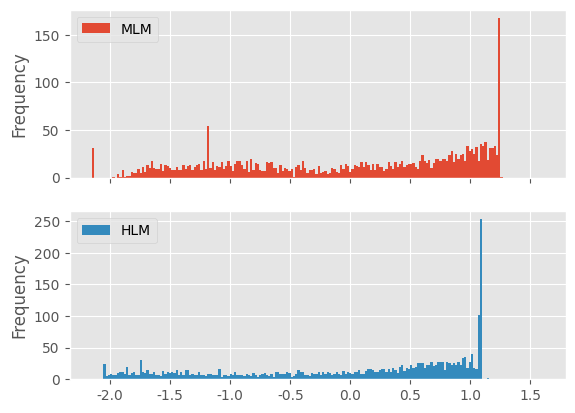

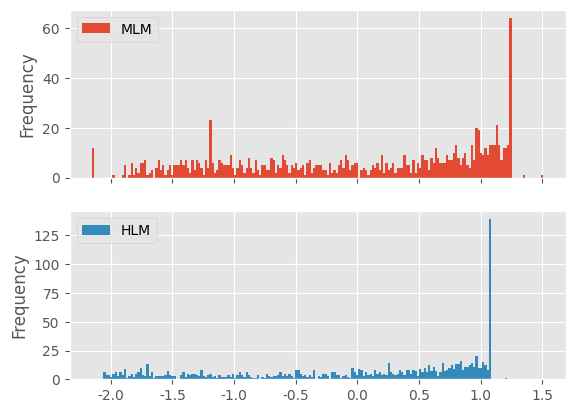

In [17]:
plot_targets(train_data)
plot_targets(val_data)

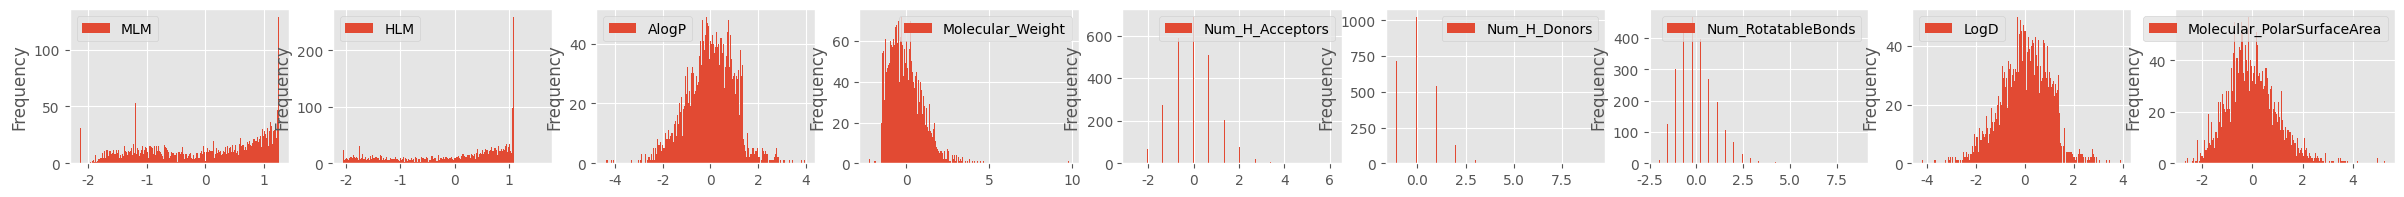

In [18]:
plot_features(train_data)

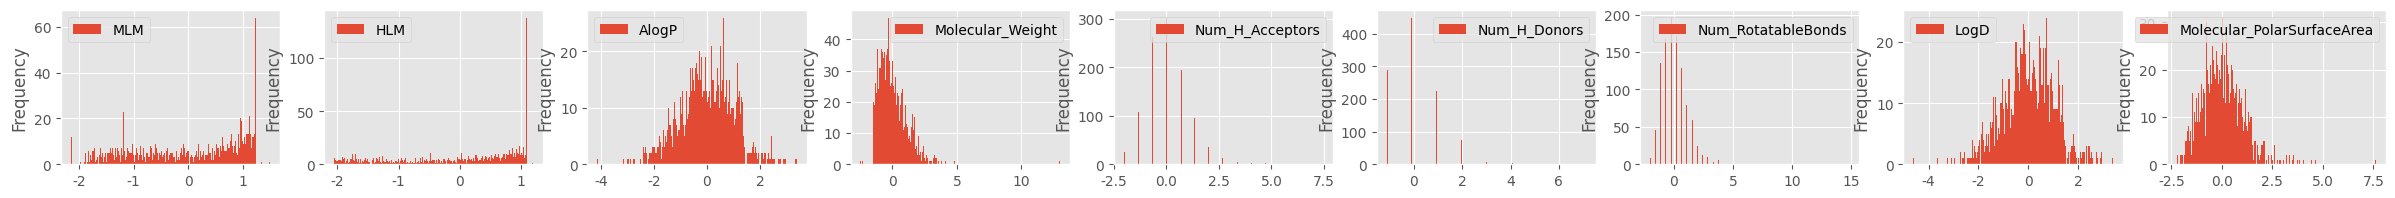

In [19]:
plot_features(val_data)

- Share same backbone and use different predictors

# SMILES → Atom, Edge features

In [ ]:
PARAMS = dict(
    batch_size=128,
    n_epochs=10000,
    node_out_feats=64,
)

In [ ]:
# def generate_dataset(df):
#     X = dc.feat.MolGraphConvFeaturizer(use_edges=True).featurize(df['SMILES'])
#     w = df[['AlogP','Molecular_Weight','Num_H_Acceptors','Num_H_Donors','Num_RotatableBonds', 'LogD', 'Molecular_PolarSurfaceArea']].values
#     return dc.data.NumpyDataset(X=X, y=df[targets].values, w=w)

# def collate_fn(samples):
#     X = [sample[0] for sample in samples]
#     y = torch.Tensor([sample[1] for sample in samples])
#     w = torch.Tensor([sample[2] for sample in samples])
#     return [X], y, w

# datasets = {data_id: generate_dataset(data) for data_id, data in zip(('train', 'val', 'test'), (train_data, val_data, test_data))}
# datasets['train'] = list(zip(datasets['train'].X, datasets['train'].y, datasets['train'].w))
# datasets['val']   = list(zip(datasets['val'].X,   datasets['val'].y,   datasets['val'].w))
# datasets['test']  = list(zip(datasets['test'].X,  datasets['test'].y,  datasets['test'].w))

# dataloaders = {
#     'train': DataLoader(datasets['train'], batch_size=PARAMS['batch_size'], collate_fn=collate_fn),
#     'val':   DataLoader(datasets['val'],   batch_size=PARAMS['batch_size'], collate_fn=collate_fn),
#     'test':  DataLoader(datasets['test'],  batch_size=1, collate_fn=collate_fn),
# }

# Modeling

In [ ]:
# class MPNN(L.LightningModule):
#     def __init__(self, batch_size, node_out_feats=64, n_tasks=2):
#         super().__init__()
#         model = MPNNModel(
#             mode='regression',
#             n_tasks=n_tasks,
#             node_out_feats=node_out_feats,
#             batch_size=batch_size,
#         )
#         self._prepare_batch = lambda batch : model._prepare_batch(batch)
#         self.model = model.model
#         self.model.model.predict = nn.Identity()
#         self.batch_size = batch_size
#         self.classifier = nn.Sequential(
#             nn.LazyLinear(node_out_feats//2),
#             nn.ReLU(),
#             nn.LazyLinear(n_tasks)
#         )
        
#         self.validation_step_outputs = []
#         self.y_scalers = y_scalers    
        
#     def forward(self, x, xp):
#         x = self.model(x)
#         x = torch.cat([x, xp], dim=-1)
#         x_out = self.classifier(x)
#         return x_out
    
#     def training_step(self, batch, batch_idx):
#         x, *_ = self._prepare_batch(batch)
#         y_true, xp = batch[1], batch[2]
#         y_pred = self(x, xp)
        
#         loss1 = F.mse_loss(y_pred[:,0].flatten(), y_true[:,0].flatten())
#         loss2 = F.mse_loss(y_pred[:,1].flatten(), y_true[:,1].flatten())
#         loss = (loss1**0.5 + loss2**0.5)/2
# #         self.log_dict({"train_loss": loss}, on_step=True, prog_bar=True, batch_size=self.batch_size)
#         self.log_dict({"train_loss": self.get_restored_loss(y_pred, y_true)}, on_step=True, prog_bar=True, batch_size=self.batch_size)
#         return loss
    
#     def validation_step(self, batch, batch_idx):
#         x, *_ = self._prepare_batch(batch)
#         y_true, xp = batch[1], batch[2]
#         y_pred = self(x, xp)
        
# #         loss1 = F.mse_loss(y_pred[:,0].flatten(), y_true[:,0].flatten())
# #         loss2 = F.mse_loss(y_pred[:,1].flatten(), y_true[:,1].flatten())
#         loss1 = F.mse_loss(
#             self.inverse_transform(y_pred[:,0].flatten(), 0),
#             self.inverse_transform(y_true[:,0].flatten(), 0)
#         )
#         loss2 = F.mse_loss(
#             self.inverse_transform(y_pred[:,1].flatten(), 1),
#             self.inverse_transform(y_true[:,1].flatten(), 1)
#         )
#         loss = (loss1, loss2)
#         self.validation_step_outputs.append(loss)
#         return loss
    
#     def on_validation_epoch_end(self):
#         loss = torch.Tensor(self.validation_step_outputs)
#         loss1, loss2 = loss[:, 0], loss[:, 1]
#         loss = ((loss1.mean())**0.5 + (loss2.mean())**0.5)/2
#         self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         self.validation_step_outputs.clear()
        
#     def predict_step(self, batch, batch_idx):
#         x, *_ = self._prepare_batch(batch)
#         y_true, xp = batch[1], batch[2]
#         y_pred = self(x, xp)
#         return y_pred
        
#     def configure_optimizers(self): 
#         optimizer = AdamW(self.model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)
#         return optimizer
    
#     def get_restored_loss(self, y_pred, y_true):
#         loss1 = F.mse_loss(
#             self.inverse_transform(y_pred[:,0].flatten(), 0),
#             self.inverse_transform(y_true[:,0].flatten(), 0)
#         )
#         loss2 = F.mse_loss(
#             self.inverse_transform(y_pred[:,1].flatten(), 1),
#             self.inverse_transform(y_true[:,1].flatten(), 1)
#         )
#         loss = ((loss1.mean())**0.5 + (loss2.mean())**0.5)/2
#         return loss
        
#     def inverse_transform(self, y, idx_target):
# #         print("y:", y.shape)
#         rst = self.y_scalers[targets[idx_target]].inverse_transform(y[:, None].cpu().detach())
#         rst = torch.from_numpy(rst.flatten())
# #         print("rst:", rst.shape)
#         return rst

In [ ]:
model = MPNN(
    n_tasks=2,
    node_out_feats=PARAMS['node_out_feats'],
    batch_size=PARAMS['batch_size']
)

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=PATH.ckpt,
    filename='MPNN-{epoch:02d}-{train_loss:.2f}-{val_loss:.2f}',
    save_top_k=1,
)

trainer = L.Trainer(
    accelerator='gpu',
#     precision='bf16-mixed',
    max_epochs=PARAMS['n_epochs'],
    callbacks=[
        checkpoint_callback,
        EarlyStopping(monitor='val_loss', patience=50),
    ],
)

In [ ]:
trainer.fit(model, dataloaders['train'], dataloaders['val'])

In [ ]:
trainer = L.Trainer(
    accelerator='gpu',
)
preds = trainer.predict(model, dataloaders['test'])

# Submission

In [ ]:
sample = pd.read_csv(PATH.sample)

In [ ]:
preds = torch.cat(preds)

In [ ]:
preds.T.shape

In [ ]:
for target, values in zip(y_scalers, preds.T):
    print(target, values)

In [ ]:
for target, values in zip(y_scalers, preds.T):
    sample[target] = y_scalers[target].inverse_transform(values[:, None])

In [ ]:
sample.to_csv(join(PATH.out, 'simple_MPNN.csv'), index=False)